In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

In [2]:
# define image directory
IMG_DIR = 'zappos_dataset'

In [3]:
# we resize our images, and normalize them
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data = datasets.ImageFolder(IMG_DIR, data_transforms)

In [4]:
# get dataset size
num_img = len(data)

In [5]:
# we divide our dataset in train and test
train_data, test_data = torch.utils.data.random_split(data, [int(num_img*0.8), num_img-int(num_img*0.8)])

In [6]:
display(len(train_data), len(test_data))

40024

10007

In [7]:
# create dataloader to feed our network with batchsize 20. For windows users, Olé :) , set num_workers to 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=False, num_workers=4)

In [8]:
# associate numbers (0..3) to class names
class_names = {x: data.classes[x] for x in range(4)}

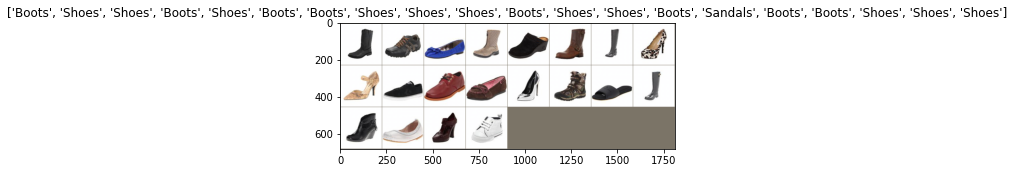

In [9]:
def imshow(inp, title=None):
    """Pour visualiser les images."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get batch, to visualize images and classes
inputs, classes = next(iter(train_loader))

# Visualize images and corresponding classes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])

In [10]:
# define model and freeze vgg16 parameters
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

In [11]:
class ZapposModel(nn.Module):
    """ Define our own model based on vgg16 model """
    def __init__(self, new_model):
        """ Create network with vgg16 featues extractor and avgpool, and adding our own classifier """
        super(ZapposModel, self).__init__()
        self.features = new_model.features
        self.avgpool = new_model.avgpool
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(2048, 4)
        )

    def forward(self, x):
        """ Forwarding pass """
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [12]:
# putting model on GPU, if gpu available, instantiate our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ZapposModel(model)
net.to(device)

ZapposModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [13]:
# we use cross entropy for loss
criterion = nn.CrossEntropyLoss()

# we update only our classifier parameters with stochastic gradient descent
optimizer = optim.SGD(net.classifier.parameters(), lr=0.001, momentum=0.9)

In [14]:
# train step
epochs = 1

len_train_data = len(train_loader)
len_test_data = len(test_loader)

for epoch in range(epochs):
    
    net.train()

    running_loss = 0.0
    for i, data in enumerate(train_loader):

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, (i+1)*20, running_loss))
            
        running_loss = 0.0
        
        # we break the loop if all the images have been used
        if (i > len_train_data):
            break
            
    
    # we evaluate our model precision on test_dataset
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        net.eval()
        for i, data in enumerate(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if (i > len_test_data):
                break 

    print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

print('Finished Training')

[1,    20] loss: 1.308
[1,   420] loss: 0.290
[1,   820] loss: 0.427
[1,  1220] loss: 0.403
[1,  1620] loss: 0.078
[1,  2020] loss: 0.197
[1,  2420] loss: 0.107
[1,  2820] loss: 0.297
[1,  3220] loss: 0.204
[1,  3620] loss: 0.449
[1,  4020] loss: 0.200
[1,  4420] loss: 0.183
[1,  4820] loss: 0.478
[1,  5220] loss: 0.287
[1,  5620] loss: 0.067
[1,  6020] loss: 0.110
[1,  6420] loss: 0.244


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nathan/.conda/envs/deep/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/nathan/.conda/envs/deep/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/nathan/.conda/envs/deep/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/nathan/.conda/envs/deep/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/nathan/.conda/envs/deep/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/nathan/.conda/envs/deep/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/nathan/.conda/envs/deep/lib/python3.6/multiprocessing/co

KeyboardInterrupt: 

In [ ]:
# empty cuda if necesary
# torch.cuda.empty_cache()